In [1]:
from neuron import h
from neuron.units import mV, ms, um
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import LFPy
import MEAutility as mu
from matplotlib.collections import LineCollection
from pathlib import Path
import MEArecTemplate as mr
import lfpykit

In [2]:
h.load_file("stdrun.hoc")

1.0

In [3]:
%run ZIAD_MEARecHelperFunctions.ipynb

In [4]:
def calc_B_field(cell, x, y, z):
    print("Calculating Magnetic Field")
    i_axial, d_vectors, pos_vectors = cell.get_axial_currents_from_vmem()
    i_axial = i_axial * 1e-9 #Convert to nA
    d_vectors = d_vectors * 1e-6 #Convert to um
    pos_vectors = pos_vectors * 1e-6 #Convert to um

    # print("Imem: ", cell.imem)
    # print("Iaxial: ", i_axial)
    # print("Imem shape: ", np.shape(cell.imem))
    # print("Iaxial shape: ", np.shape(i_axial))
    #print("CDP: ", current_dipole_moment)
    #print("CDP shape: ", np.shape(current_dipole_moment))

    #print("I_axial: ", i_axial)
    #print("D_vectors: ", d_vectors)
    #print("Pos_vectors: ", pos_vectors)

    num_elecs = len(x)
    time_len = len(cell.tvec)
    dims = 3
    all_B_fields = np.zeros((num_elecs, dims, time_len))

    for i in range(len(x)):
        R = np.array([x[i], y[i], z[i]])
        R = R * 1e-6 #Convert to um
        #print(R)
        B = calc_B_field_single_sensor(cell, R, i_axial, d_vectors, pos_vectors)
        all_B_fields[i] = B

    return all_B_fields

def calc_B_field_single_sensor(cell, R, i_axial, d_vectors, pos_vectors):
    B = np.zeros((3, cell.tvec.size))

    count = 0
    r_rel = R - pos_vectors
    cross = np.cross(d_vectors.T, r_rel)
    divisor = 1e7 * np.sqrt((r_rel**2).sum(axis=1))**3
    vec = cross / np.expand_dims(divisor, axis=0).T

    count = 0
    for ax_curr in i_axial.T:
        B[:, count] = ax_curr @ vec
        count += 1

    return B
            
def get_M(cell, x, y, z, sigma):
    """Loop over electrode contacts, and return LFPs across channels"""
    M = np.zeros((x.size, cell.x.shape[0]))
    r_limit = cell.d / 2
    for i in range(x.size):
        M[i, :] = lfpykit.lfpcalc.calc_lfp_linesource(cell = cell,
                                  x=x[i],
                                  y=y[i],
                                  z=z[i],
                                  sigma=sigma,
                                  r_limit=r_limit)
    return M

def get_spike_data(sig, elec=False, basic=False, ret_points=False):
    if basic == True:
        return abs(np.max(sig) - np.min(sig))
        
    sig = sig - sig[0]
    spike_max_idx = np.argmax(sig)
    spike_min_idx = np.argmin(sig)
    
    if spike_max_idx > spike_min_idx or elec==True:
        first_idx = spike_min_idx
        second_idx = np.argmax(sig[first_idx:])+first_idx
    else:
        first_idx = spike_max_idx
        second_idx = np.argmin(sig[first_idx:])+first_idx
        
    #print(first_idx, second_idx)
    #print(sig[first_idx], sig[second_idx])
    if ret_points:
        return abs(sig[first_idx] - sig[second_idx]), first_idx, second_idx
    
    return abs(sig[first_idx] - sig[second_idx])

### Initialize Cell

In [117]:
T = 50
dt = 0.03125
v_init = -65
radial_scaling = True
# # Radial Scaling
# dist_along_axon = 10

# # Axial scaling
# dist_from_axon = 50

# Retrieve cell
all_cells = ['L5_DBC_bAC217_1',
             'L5_MC_bAC217_1',
             'L5_TTPC1_cADpyr232_1',
             'L5_TTPC2_cADpyr232_1',
             'L5_STPC_cADpyr232_1',
             'L5_UTPC_cADpyr232_1']

cell_name = all_cells[2]
mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
cell = mr.return_bbp_cell(cell_model_folder, 
                          end_T = T, 
                          dt = dt, 
                          start_T = 0)

# # Radial scaling
# if radial_scaling == True:
#     cell.set_rotation(np.pi, -np.pi/2, np.pi, 'zyx')
#     cell.set_pos(-10, -1*dist_along_axon, -500)

# # Axial scaling
# else:
#     cell.set_rotation(np.pi+np.pi/50, -np.pi/2, np.pi, 'zyx')
#     cell.set_pos(-10, -500, -1*dist_from_axon)

# Flatten cell to within x = 5-25 um range
pos = [0, 0, 0]
rot = [0, 0, 0]
cell = mr.ziad_flatten_geometry(cell, pos, rot, None)
cell._update_pt3d()

NEURON: cADpyr232_biophys : a template cannot be redefined
 in biophysics.hoc near line 33
 begintemplate cADpyr232_biophys
                               ^
        xopen("biophysics.hoc")
      execute1("{xopen("bi...")
    load_file(1, "biophysics.hoc")


Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
	1 
	1 
	1 
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string
Ziad Flatten Position:  [0, 0, 0]
Ziad Faltten Rotation:  [0, 0, 0]


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_50657/3864615857.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X, Y, '.', marker='o', markersize=3, color='k', zorder=0)


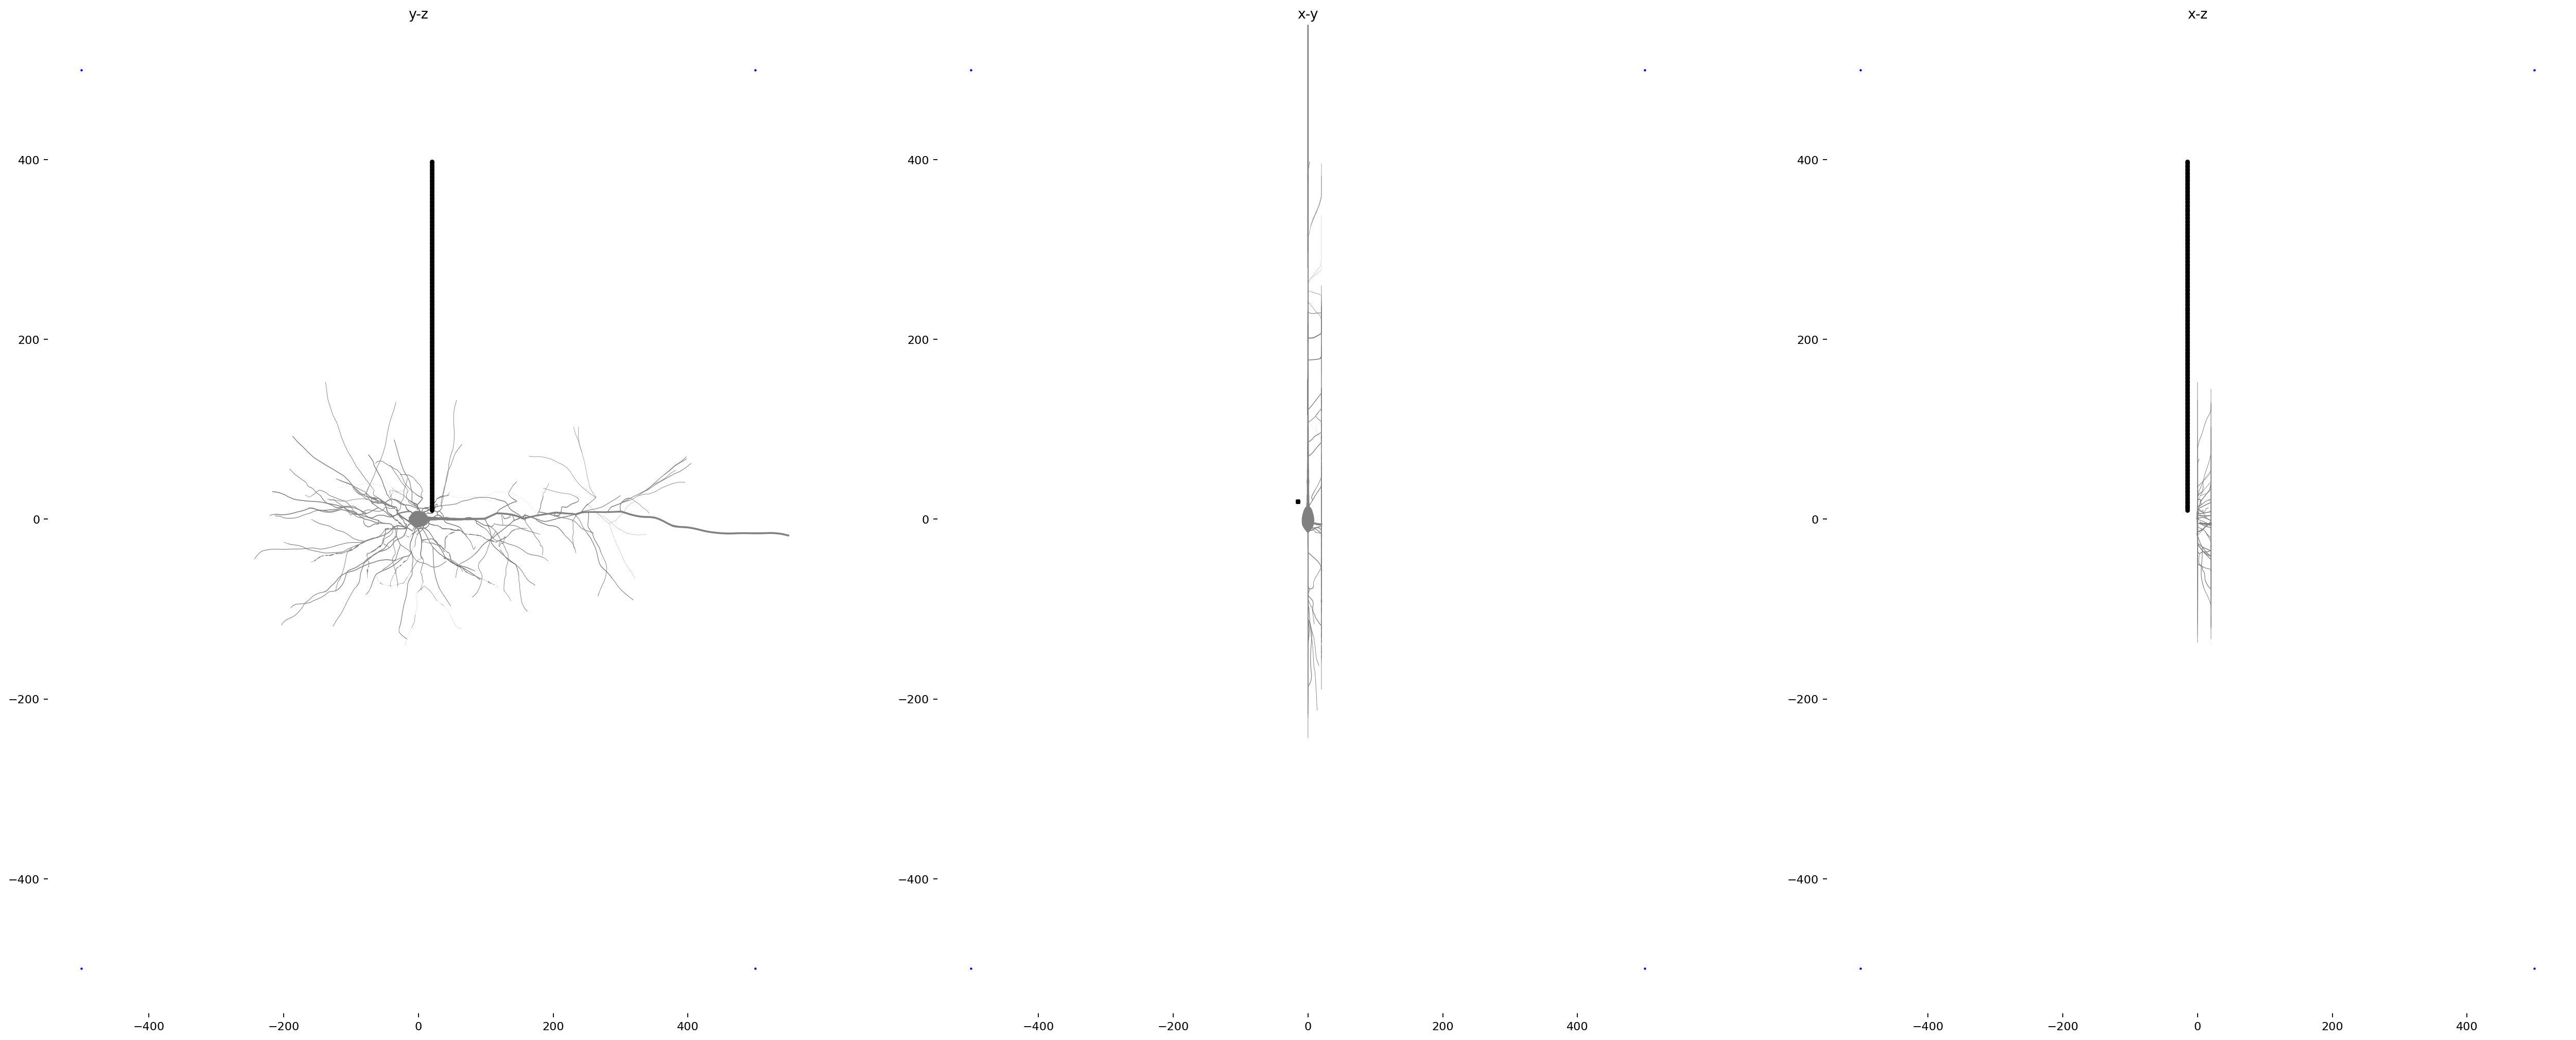

In [120]:
# Radial scaling measurement positions
z = np.arange(10, 400, 2)
x = z*0 - 15
y = x*0 + 20

fig = plotcell_3planes2(cell, x, y, z, lim=500, plot_electrodes=True)

### Connect stimulus to cell

In [121]:
for sec in cell.allseclist:
    if 'soma' in str(sec):
        print(sec)
        break
        
soma = sec

# Create synapse
syn = h.IClamp(0.5, sec=soma)
syn.dur = 60
syn.delay = 5

# Create vector to "play" stimulus into cell - can be time-varying if desired
weight = 0.75
tot_ntsteps = int(round(T / dt + 1))
I = np.ones(tot_ntsteps) * weight
noiseVec = h.Vector(I)

noiseVec.play(syn._ref_amp, dt)

cADpyr232_L5_TTPC1_0fb1ca4724[0].soma[0]


Vector[183491]

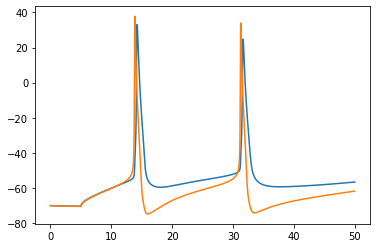

In [122]:
cell.simulate(rec_imem=True, rec_vmem=True)
t = np.arange(0, T+dt, dt)

#plt.plot(np.arange(0, T+dt, dt), cell.somav)
plt.plot(t, cell.vmem[0])
plt.plot(t, cell.vmem[-1])

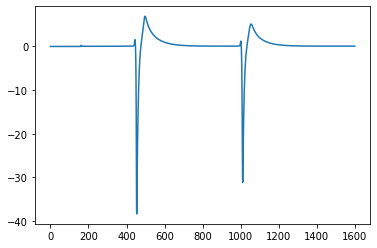

In [123]:
plt.plot(cell.imem[0])

### Calculate LFP

In [124]:
sigma = 0.3 # Extracellular conductivity

M = get_M(cell, x, y, z, sigma)
lfp = M @ cell.imem

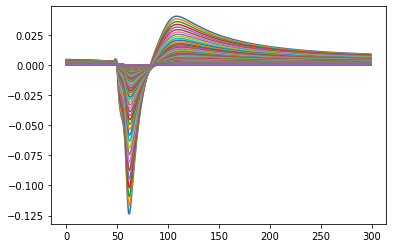

In [125]:
for i in range(len(lfp)):
    plt.plot(lfp[i][950:1250])
    #plt.plot(lfp[i][750:1050])

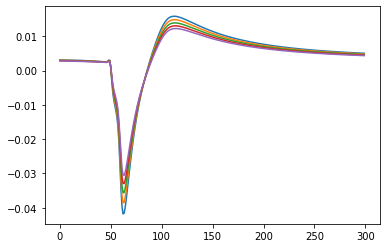

In [126]:
# plt.plot(lfp[0][950:1250])
# plt.plot(lfp[10][950:1250])
for i in range(14, 19):
    plt.plot(lfp[i][950:1250])
# plt.plot(lfp[30][950:1250])
# plt.plot(lfp[40][950:1250])
# plt.plot(lfp[50][950:1250])
# plt.plot(lfp[60][950:1250])

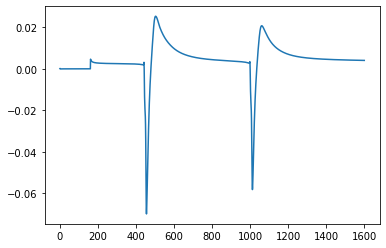

In [127]:
plt.plot(lfp[10])

### Calculate B Field

In [128]:
all_B = calc_B_field(cell, x, y, z)

Calculating Magnetic Field
Pos shape old:  (2648, 3)


In [129]:
B_tot = np.sqrt(np.sum(all_B**2, axis=1))
new_all_B = np.zeros((np.shape(all_B)[0], np.shape(all_B)[1]+1, np.shape(all_B)[2]))
new_all_B[:, 0:3, :] = all_B
new_all_B[:, 3, :] = B_tot
all_B = new_all_B

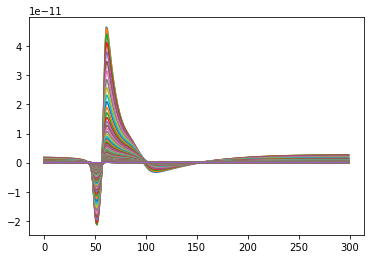

In [130]:
for i in range(len(all_B)):
    plt.plot(all_B[i][0][950:1250])

### Calculate Scaling

In [131]:
start_idx = 950
end_idx = 1250
idxs = slice(start_idx,end_idx)

data_pp_all = []
data_roc_all = []

# Iterate through V, Bx, Bz
for i in [-1, 0, 2, 3]:
    if i == -1:
        data = np.copy(lfp[:, idxs])
    else:
        data = np.copy(all_B[:, i, idxs])
        
    data_pp = []
    for n in range(len(data)):
        sig_pp = get_spike_data(data[n], basic=True)
        data_pp.append(sig_pp)
        
    data_pp = np.array(data_pp)
    data_pp = data_pp / np.max(data_pp)
    logdata = np.log10(data_pp)
    
    # Distance between electrodes
    r = abs(z - cell.z3d[0][0])
    logr = np.log10(r)
    
    # Rate of change (exponent) is log(data)/log(r)
    roc = (logdata[1:] - logdata[:-1])/(logr[1:] - logr[:-1])
    
    data_pp_all.append(data_pp)
    data_roc_all.append(roc)

Text(0, 0.5, 'Normalized Peak-Peak Magnitude')

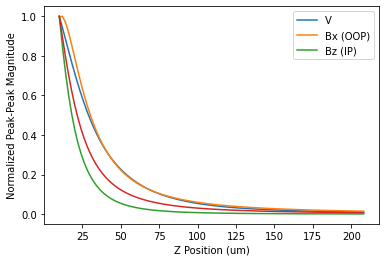

In [132]:
# Plot magnitude scaling
plot_idx = 100
for i in range(len(data_pp_all)):
    plt.plot(z[:plot_idx], data_pp_all[i][:plot_idx])
    
plt.legend(['V', 'Bx (OOP)', 'Bz (IP)'])
plt.xlabel('Z Position (um)')
plt.ylabel('Normalized Peak-Peak Magnitude')

Text(0, 0.5, 'Normalized Peak-Peak Magnitude')

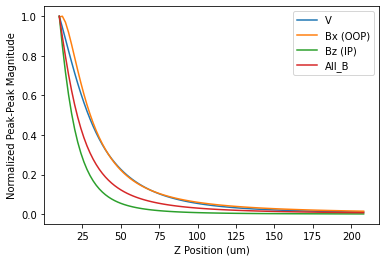

In [133]:
# Plot magnitude scaling
plot_idx = 100
for i in range(len(data_pp_all)):
    plt.plot(z[:plot_idx], data_pp_all[i][:plot_idx])
    
plt.legend(['V', 'Bx (OOP)', 'Bz (IP)', 'All_B'])
plt.xlabel('Z Position (um)')
plt.ylabel('Normalized Peak-Peak Magnitude')

Text(0, 0.5, 'Rate of Change (Exponent)')

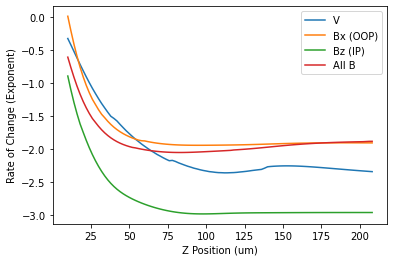

In [134]:
# Plot rate of change of scaling

for i in range(len(data_roc_all)):
    plt.plot(abs(z[:plot_idx]), data_roc_all[i][:plot_idx])
    
plt.legend(['V', 'Bx (OOP)', 'Bz (IP)', 'All B'])
plt.xlabel('Z Position (um)')
plt.ylabel('Rate of Change (Exponent)')

In [88]:
z

array([ -10,  -12,  -14,  -16,  -18,  -20,  -22,  -24,  -26,  -28,  -30,
        -32,  -34,  -36,  -38,  -40,  -42,  -44,  -46,  -48,  -50,  -52,
        -54,  -56,  -58,  -60,  -62,  -64,  -66,  -68,  -70,  -72,  -74,
        -76,  -78,  -80,  -82,  -84,  -86,  -88,  -90,  -92,  -94,  -96,
        -98, -100, -102, -104, -106, -108, -110, -112, -114, -116, -118,
       -120, -122, -124, -126, -128, -130, -132, -134, -136, -138, -140,
       -142, -144, -146, -148, -150, -152, -154, -156, -158, -160, -162,
       -164, -166, -168, -170, -172, -174, -176, -178, -180, -182, -184,
       -186, -188, -190, -192, -194, -196, -198, -200, -202, -204, -206,
       -208, -210, -212, -214, -216, -218, -220, -222, -224, -226, -228,
       -230, -232, -234, -236, -238, -240, -242, -244, -246, -248, -250,
       -252, -254, -256, -258, -260, -262, -264, -266, -268, -270, -272,
       -274, -276, -278, -280, -282, -284, -286, -288, -290, -292, -294,
       -296, -298, -300, -302, -304, -306, -308, -3

In [58]:
for i in range(len(z[:plot_idx])):
    print(z[:plot_idx][i], 
          data_roc_all[0][:plot_idx][i], 
          data_roc_all[1][:plot_idx][i], 
          data_roc_all[2][:plot_idx][i],
          data_roc_all[3][:plot_idx][i])

10 -0.31890852069484404 0.018881367063223246 -0.8885851071516919 -0.6021152374603358
12 -0.41568065808317767 -0.20009968156694385 -1.0979860710753904 -0.7587305797623699
14 -0.514987332626998 -0.4041654794617859 -1.2895400275486932 -0.9064878365123386
16 -0.6144957921009085 -0.5891110203829674 -1.4618423351711636 -1.0421855552224801
18 -0.7128021744770244 -0.754115734964255 -1.616158512378548 -1.1646440122395285
20 -0.8076058909988001 -0.9001784984163289 -1.7416742605954532 -1.274020047181636
22 -0.9002308778048844 -1.0290570745175758 -1.86453166536596 -1.3711816635084886
24 -0.9897275937816422 -1.142659483024732 -1.9779421485093096 -1.4572586880049199
26 -1.0748622663719833 -1.2417895745822658 -2.0811381493871455 -1.5333970404711432
28 -1.1546989419433697 -1.3211029186542718 -2.1748489218756424 -1.5929377430005025
30 -1.2321544187467874 -1.3997929636395248 -2.2595980879378326 -1.6518971147595294
32 -1.3052683874993558 -1.469131442427257 -2.335845749197278 -1.7044882219706532
34 -1.372

Text(0, 0.5, 'Rate of Change (Exponent)')

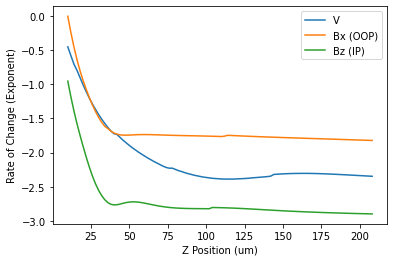

In [139]:
# Plot rate of change of scaling

for i in range(len(data_roc_all)):
    plt.plot(z[:plot_idx], data_roc_all[i][:plot_idx])
    
plt.legend(['V', 'Bx (OOP)', 'Bz (IP)'])
plt.xlabel('Z Position (um)')
plt.ylabel('Rate of Change (Exponent)')

### Calculate Average Scaling

In [104]:
z_range = (10, 400)
z_step = 2
y_range = (0, 51)
y_step = 2

neg_z = True
if neg_z:
    z_range = (-z_range[1], -z_range[0])

z_base = np.arange(z_range[0], z_range[1], z_step)
y_base = np.arange(y_range[0], y_range[1], y_step)
total_coords = len(z_base)*len(y_base)

z = np.zeros((total_coords,))
y = np.zeros((total_coords,))
x = np.zeros((total_coords,)) - 15

count = 0
for i in range(len(y_base)):
    for j in range(len(z_base)):
        z[count] = z_base[j]
        y[count] = y_base[i]
        count += 1

In [105]:
y_base

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50])

In [106]:
T = 50
dt = 0.03125
v_init = -65
radial_scaling = True
# # Radial Scaling
# dist_along_axon = 10

# # Axial scaling
# dist_from_axon = 50

# Retrieve cell
all_cells = ['L5_DBC_bAC217_1',
             'L5_MC_bAC217_1',
             'L5_TTPC1_cADpyr232_1',
             'L5_TTPC2_cADpyr232_1',
             'L5_STPC_cADpyr232_1',
             'L5_UTPC_cADpyr232_1']

cell_idx = 5
cell_name = all_cells[cell_idx]
mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
cell = mr.return_bbp_cell(cell_model_folder, 
                          end_T = T, 
                          dt = dt, 
                          start_T = 0)

# # Radial scaling
# if radial_scaling == True:
#     cell.set_rotation(np.pi, -np.pi/2, np.pi, 'zyx')
#     cell.set_pos(-10, -1*dist_along_axon, -500)

# # Axial scaling
# else:
#     cell.set_rotation(np.pi+np.pi/50, -np.pi/2, np.pi, 'zyx')
#     cell.set_pos(-10, -500, -1*dist_from_axon)

# Flatten cell to within x = 5-25 um range
pos = [0, 0, 0]
rot = [0, 0, 0]
cell = mr.ziad_flatten_geometry(cell, pos, rot, None)
cell._update_pt3d()

cell.set_pos(pos[0], pos[1], pos[2])
cell.set_rotation(rot[0], rot[1], rot[2])

Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_UTPC_5e3840b51e exist already
Morphology:  morphology/dend-Fluo15_left_axon-Fluo15_left_-_Scale_x1.000_y0.950_z1.000_-_Clone_30.asc
Type:  <class 'str'>
Morphology is a string
Ziad Flatten Position:  [0, 0, 0]
Ziad Faltten Rotation:  [0, 0, 0]


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_50657/3864615857.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X, Y, '.', marker='o', markersize=3, color='k', zorder=0)


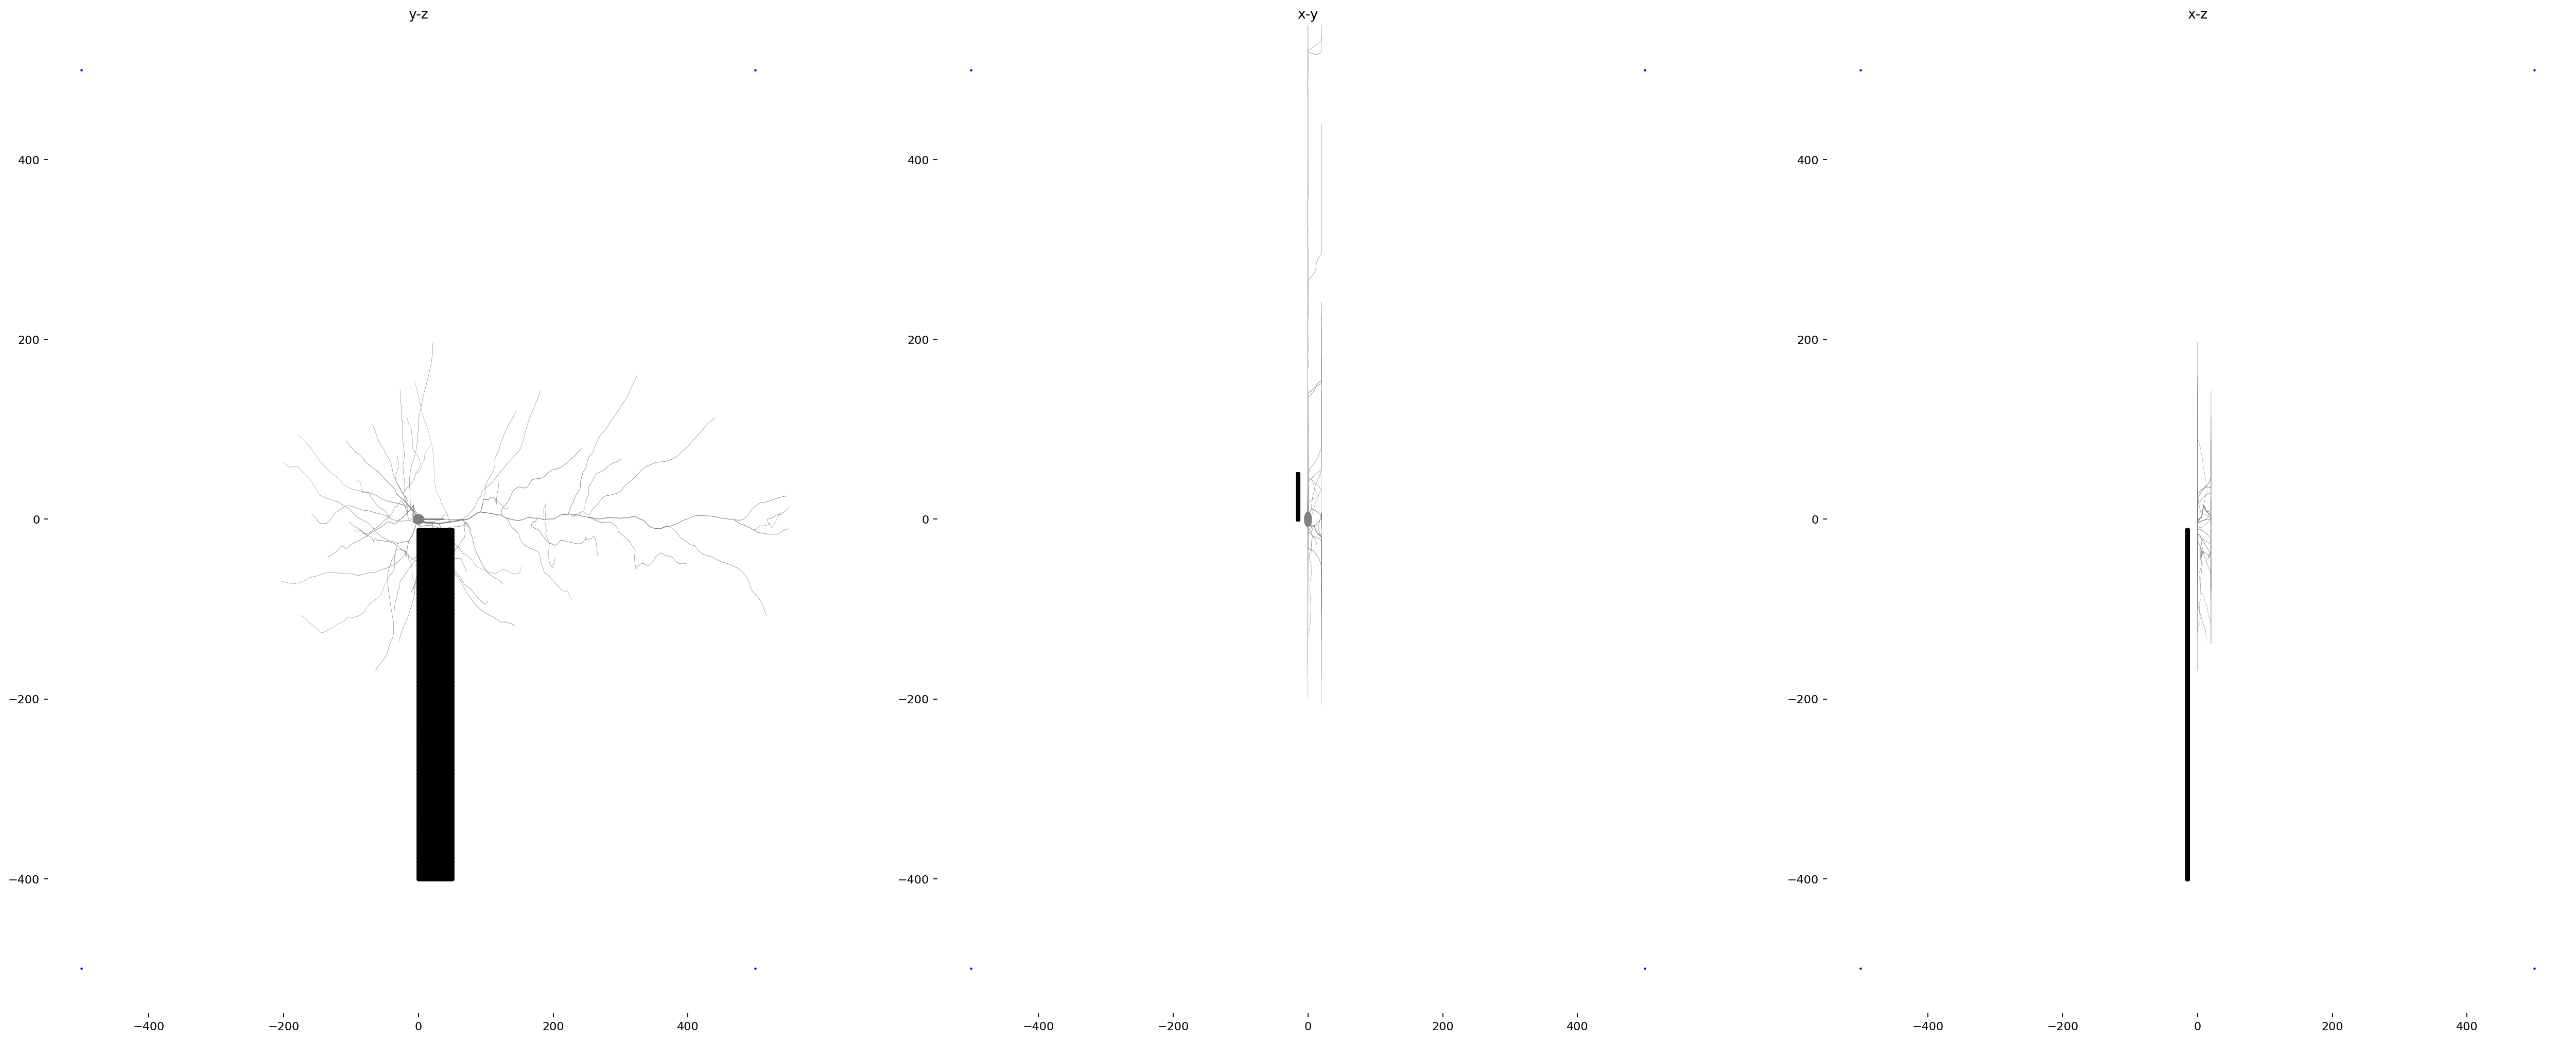

In [107]:
fig = plotcell_3planes2(cell, x, y, z, lim=500, plot_electrodes=True)

In [108]:
for sec in cell.allseclist:
    if 'soma' in str(sec):
        print(sec)
        break
        
soma = sec

# Create synapse
syn = h.IClamp(0.5, sec=soma)
syn.dur = 60
syn.delay = 5

# Create vector to "play" stimulus into cell - can be time-varying if desired
weight = 0.75
tot_ntsteps = int(round(T / dt + 1))
I = np.ones(tot_ntsteps) * weight
noiseVec = h.Vector(I)

noiseVec.play(syn._ref_amp, dt)

cell.simulate(rec_imem=True, rec_vmem=True)
t = np.arange(0, T+dt, dt)

cADpyr232_L5_UTPC_5e3840b51e[1].soma[0]


In [109]:
sigma = 0.3 # Extracellular conductivity

M = get_M(cell, x, y, z, sigma)
lfp = M @ cell.imem

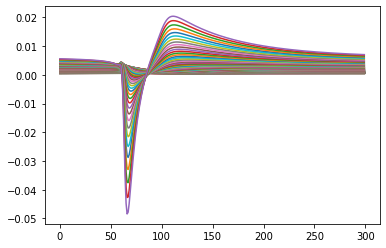

In [110]:
n = 0
start_idx = 950
end_idx = 1250
for i in range(len(z_base)):
    plt.plot(lfp[n*len(z_base) + i, start_idx:end_idx])

In [111]:
all_B = calc_B_field(cell, x, y, z)

Calculating Magnetic Field
Pos shape old:  (1438, 3)


In [112]:
start_idx = 950
end_idx = 1250
if cell_idx == 4:
    start_idx = 750
    end_idx = 1050
elif cell_idx == 0:
    start_idx = 1050
    end_idx = 1350
elif cell_idx == 1:
    start_idx = 850
    end_idx = 1150
idxs = slice(start_idx,end_idx)

pp_all = []
roc_all = []

for n in range(len(y_base)):
    data_pp_all = []
    data_roc_all = []

    # Iterate through V, Bx, Bz
    for i in [-1, 0, 2]:
        if i == -1:
            data = np.copy(lfp[n*len(z_base):(n+1)*len(z_base), idxs])
        else:
            data = np.copy(all_B[n*len(z_base):(n+1)*len(z_base), i, idxs])

        data_pp = []
        for k in range(len(data)):
            sig_pp = get_spike_data(data[k], basic=True)
            data_pp.append(sig_pp)

        data_pp = np.array(data_pp)
        data_pp = data_pp / np.max(data_pp)
        logdata = np.log10(data_pp)

        # Distance between electrodes
        r = abs(z_base - cell.z3d[0][0])
        logr = np.log10(r)

        # Rate of change (exponent) is log(data)/log(r)
        roc = (logdata[1:] - logdata[:-1])/(logr[1:] - logr[:-1])

        data_pp_all.append(data_pp)
        data_roc_all.append(roc)
    
    pp_all.append(data_pp_all)
    roc_all.append(data_roc_all)
    
pp_all = np.array(pp_all)
roc_all = np.array(roc_all)

In [113]:
np.shape(roc_all)

(26, 3, 194)

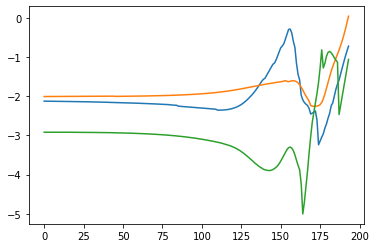

In [114]:
idx = 0
plot_idx = 100

for i in [0, 1, 2]:
    plt.plot(roc_all[idx, i, :])

In [116]:
terminal_rocs = np.zeros((3, len(y_base)))

idx_200um = 95
if neg_z == True:
    idx_200um = 100
for i in range(len(roc_all)):
    for j in range(np.shape(roc_all)[1]):
        print(roc_all[i, j, idx_200um], end='\t')
        terminal_rocs[j, i] = roc_all[i, j, idx_200um]
    print()

-2.30276928483354	-1.9381330260817482	-3.097570746689522	
-2.2988983085554238	-1.9430042957512492	-3.045884749350419	
-2.2947795281638954	-1.947474222619598	-2.9937377785529895	
-2.290471302400621	-1.9515348076970038	-3.0217243221556296	
-2.2860289610129834	-1.9551780604867615	-3.0464098605922785	
-2.281504444534559	-1.9583959818052101	-3.068137095416829	
-2.2769459882529666	-1.961180559520565	-3.087192411928685	
-2.2723978527331816	-1.9635237769671516	-3.1038173586075017	
-2.2679001037997875	-1.9654176334178795	-3.1182174422354003	
-2.2634884434267217	-1.966854175625557	-3.1305689438084516	
-2.257172864230445	-1.9678255390930026	-3.1553465972156975	
-2.2532355288525916	-1.9683239974369056	-3.178612642820576	
-2.2494514199541538	-1.968342017954197	-3.188068471598372	
-2.245838727711425	-1.9678723213546152	-3.1957725635546734	
-2.2424111718401574	-1.9669079435438828	-3.2018382607144558	
-2.239178133742506	-1.9654422973757035	-3.230754212848193	
-2.2361448268879918	-1.9634692324198333	-3

In [33]:
a = 5

In [147]:
print(np.mean(terminal_rocs, axis=1))
print(np.std(terminal_rocs, axis=1))

[-2.57246298 -1.92989247 -2.99183571]
[0.3421126  0.02760157 0.0461705 ]


In [112]:
def get_roc(data_pp, z):
    logdata = np.log10(data_pp)

    # Distance between electrodes
    r = abs(z - cell.z3d[0][0])
    logr = np.log10(r)

    # Rate of change (exponent) is log(data)/log(r)
    roc = (logdata[1:] - logdata[:-1])/(logr[1:] - logr[:-1])
    
    return roc

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


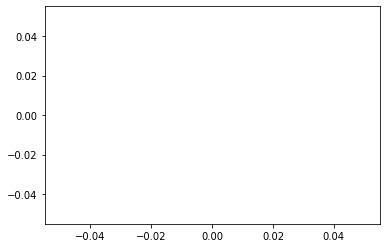

In [113]:
start = 20
end = 30
for i in range(3):
    plt.plot(get_roc(np.mean(pp_all[start:end, i, :], axis=0), z_base))

In [ ]:
def get_axial_currents_from_vmem(coords, timepoints=None):
    
    ri_list = get_axial_resistance()
    i_axial = []
    d_vectors = []
    pos_vectors = []
    dseg = np.c_[coords.x.mean(axis=-1) - coords.x[:, 0],
                 coords.y.mean(axis=-1) - coords.y[:, 0],
                 coords.z.mean(axis=-1) - coords.z[:, 0]]
    dpar = np.c_[coords.x[:, -1] - coords.x.mean(axis=-1),
                 coords.y[:, -1] - coords.y.mean(axis=-1),
                 coords.z[:, -1] - coords.z.mean(axis=-1)]

    # children_dict = self.get_dict_of_children_idx()
    # print("All secs: ")
    # for sec in self.allseclist:
    #     print(sec)
    for sec in h.allsec():
        #print("Axial currents sec: ", sec)
        if not h.SectionRef(sec=sec).has_parent():
            if sec.nseg == 1:
                # skip soma, since soma is an orphan
                continue
            else:
                # the first segment has more than one segment,
                # need to compute axial currents within this section.
                seg_idx = 1
                parent_idx = 0
                bottom_seg = False
                first_sec = True
                branch = False
                parentsec = None
                children_dict = None
                connection_dict = None
                conn_point = 1
        else:
            # section has parent section
            first_sec = False
            bottom_seg = True
            secref = h.SectionRef(sec=sec)
            parentseg = secref.parent()
            parentsec = parentseg.sec
            children_dict = self.get_dict_of_children_idx()
            branch = len(children_dict[parentsec.name()]) > 1
            connection_dict = self.get_dict_parent_connections()
            conn_point = connection_dict[sec.name()]
            # find parent index
            if conn_point == 1 or parentsec.nseg == 1:
                internal_parent_idx = -1  # last seg in sec
            elif conn_point == 0:
                internal_parent_idx = 0  # first seg in sec
            else:
                # if parentseg is not first or last seg in parentsec
                segment_xlist = np.array(
                    [segment.x for segment in parentsec])
                internal_parent_idx = np.abs(
                    segment_xlist - conn_point).argmin()
            parent_idx = self.get_idx(section=parentsec.name())[
                internal_parent_idx]
            # find segment index
            seg_idx = self.get_idx(section=sec.name())[0]
        for _ in sec:
            if first_sec:
                first_sec = False
                continue
            iseg, ipar = self._parent_and_segment_current(seg_idx,
                                                          parent_idx,
                                                          bottom_seg,
                                                          branch,
                                                          parentsec,
                                                          children_dict,
                                                          connection_dict,
                                                          conn_point,
                                                          timepoints,
                                                          sec
                                                          )
            #print(iseg, ipar)

            if bottom_seg:
                # if a seg is connected to soma, it is
                # connected to the middle of soma,
                # and dpar needs to be altered.
                par_dist = np.array([(self.x[seg_idx, 0] -
                                      self.x[parent_idx].mean(axis=-1)),
                                     (self.y[seg_idx, 0] -
                                      self.y[parent_idx].mean(axis=-1)),
                                     (self.z[seg_idx, 0] -
                                      self.z[parent_idx].mean(axis=-1))])

            else:
                par_dist = dpar[parent_idx]
            d_vectors.append(par_dist)
            d_vectors.append(dseg[seg_idx])
            i_axial.append(ipar)
            i_axial.append(iseg)

            pos_par = np.array([self.x[seg_idx, 0],
                                self.y[seg_idx, 0],
                                self.z[seg_idx, 0]]) - 0.5 * par_dist

            pos_seg = np.array([self.x[seg_idx].mean(axis=-1),
                                self.y[seg_idx].mean(axis=-1),
                                self.z[seg_idx].mean(axis=-1)])
            pos_seg -= 0.5 * dseg[seg_idx]
            pos_vectors.append(pos_par)
            pos_vectors.append(pos_seg)

            parent_idx = seg_idx
            seg_idx += 1
            branch = False
            bottom_seg = False

    print("Pos shape old: ", np.shape(pos_vectors))

    return np.array(i_axial), np.array(d_vectors).T, np.array(pos_vectors)